# PS reconstruction, Gaussian beam, t scan study

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
yaml_dir = os.path.join('data', 'yaml_files')
save_dir = os.path.join('data', 'gaussian_beam', 't_scan')
p0c = 43.36e6 # reference momentum in eV/c
#gt_beam = create_beam(
#    base_yaml = os.path.join(yaml_dir, 'gaussian.yaml'),
#    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear.yaml'), 
#    p0c = p0c,
#    n_particle = 1_000_000,
#    save_as = os.path.join(save_dir, 'gaussian_beam.pt')
#)
gt_beam = torch.load(os.path.join(save_dir, 'gaussian_beam.pt'))

0.017683694
0.001163028


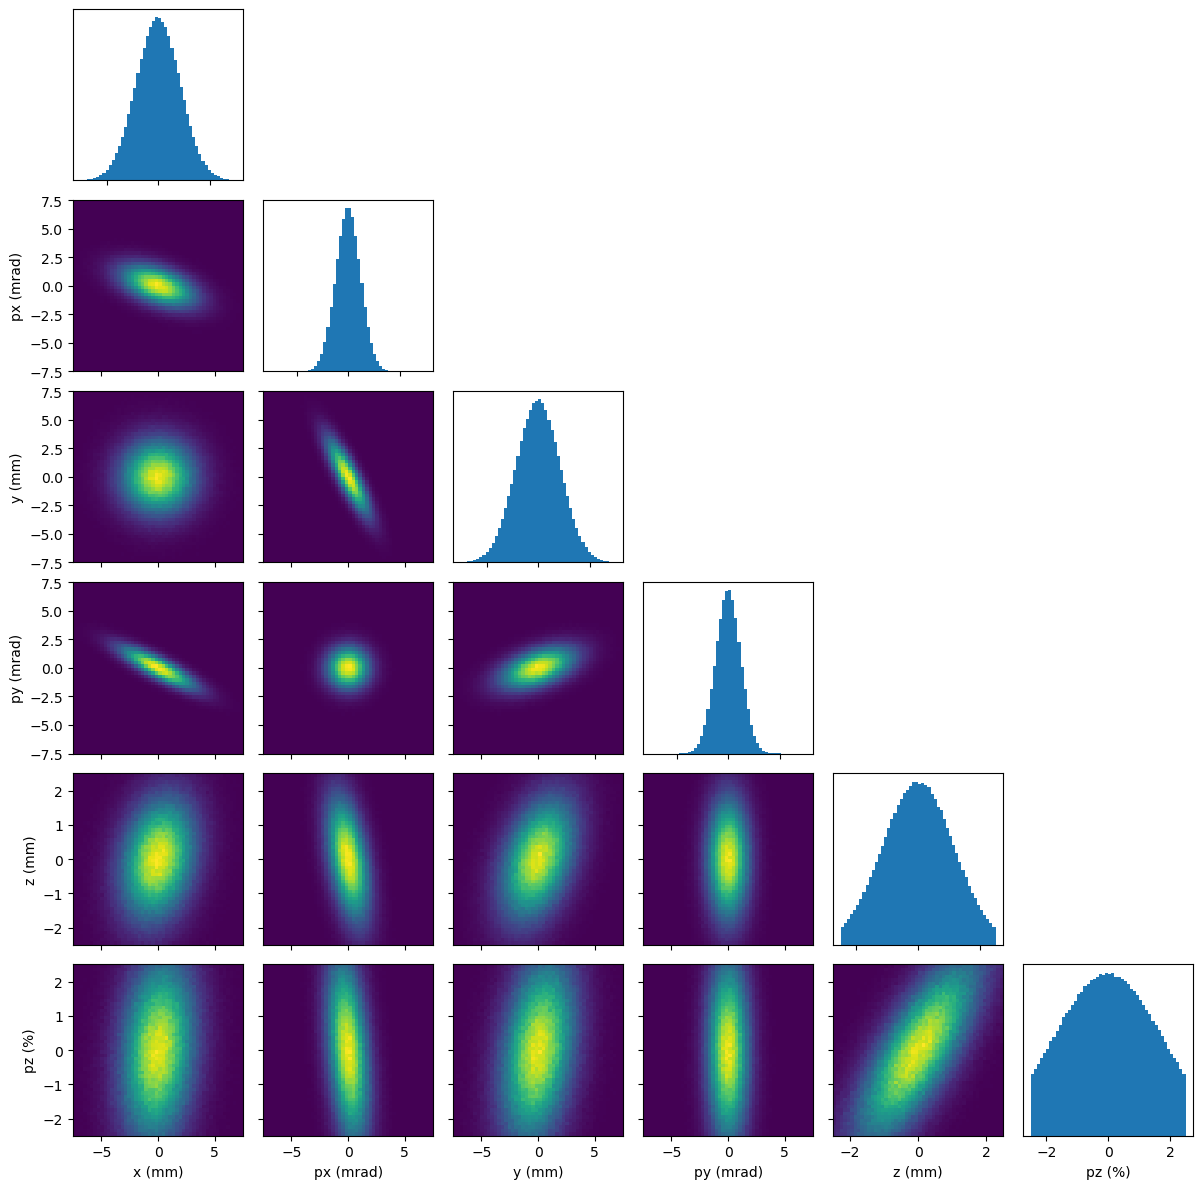

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]])*0.5
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
print(np.std(gt_beam.numpy_particles().pz))
print(np.std(gt_beam.numpy_particles().z))

plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =    10.986991
k2 =   -24.674763
k3 =    26.907939

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 1e7]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-25, 25, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

## 'T' scan training data

torch.Size([8, 3, 1])
torch.Size([8, 1, 200, 200])


/global/homes/r/rroussel/.conda/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1694463969407/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


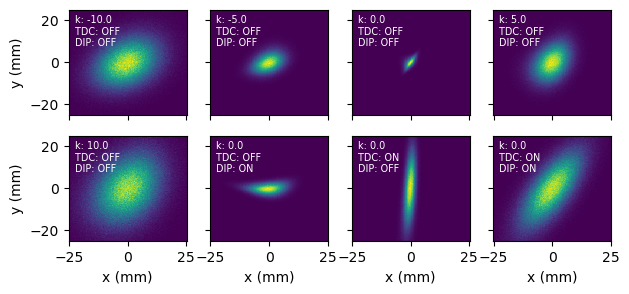

In [6]:
# generate and save train and test datasets
#train_dset_t_scan = run_t_scan(
#    gt_beam, 
#    lattice,
#    screen, 
#    ks, vs, gs,
#    ids = scan_ids,
#    save_as = os.path.join(save_dir, 't_scan_train.dset')
#    )
train_dset_t_scan = torch.load(os.path.join(save_dir, 't_scan_train.dset'))

print(train_dset_t_scan.params.shape)
print(train_dset_t_scan.images.shape)

fig, ax = plt.subplots(2,4,sharex="all",sharey="all",figsize=(7,3))
xx = torch.meshgrid(bins*1e3, bins*1e3)
params = train_dset_t_scan.params.squeeze()

for i, ele in enumerate(ax.flatten()):
    ele.pcolor(xx[0].numpy(),xx[1].numpy(), train_dset_t_scan.images[i, 0].numpy(), 
               rasterized=True)#,vmax=1.1*torch.max(train_dset_t_scan.images))
    dip = "ON" if params[i,2] > 0.1 else "OFF"
    tdc = "ON" if params[i,1] > 0.1 else "OFF"
    ele.text(
        0.05,0.95,
        f"k: {params[i][0]}\nTDC: {tdc}\nDIP: {dip}",
        fontdict={"color":"white","size":"x-small"},
        transform=ele.transAxes,
        va="top",
        ha="left"
    )
for a in ax[-1,:]:
    a.set_xlabel("x (mm)")

for a in ax[:,0]:
    a.set_ylabel("y (mm)")

fig.savefig("t_scan_gaussian_E_corr_data.svg")
#for ele in train_dset_t_scan.images:
#    plt.figure()
#    plt.imshow(ele.squeeze())

In [ ]:
import torch
from stats import plot_projections_with_contours, show_cov_stats, plot_prab_figure
import os

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-7, 7],
                 [-10, 10]])*0.5

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig = plot_prab_figure(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 95],
    custom_lims=lims,
)
fig.savefig("gaussian_reconstruction_E_corr_t_scan.svg")